In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

spm = pd.read_csv('SPM/spm_results.csv', sep=',')

spm

,config,memorder,voting-strat,tpb,ipt,formula,problemsize,runtime
0,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,invariantly_inevitably_eat,2,0.96800005
1,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,invariantly_inevitably_eat,4,14.787
2,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,invariantly_inevitably_eat,6,1000.004
3,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,invariantly_inevitably_eat,8,12585.703
4,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,invariantly_inevitably_eat,10,non-zero exitcode.
...,...,...,...,...,...,...,...,...
155,acqrel-naive-alternating-128-4,acqrel,naive-alternating,128,4,invariantly_inevitably_eat,2,2.2399998
156,acqrel-naive-alternating-128-4,acqrel,naive-alternating,128,4,invariantly_inevitably_eat,4,45.222
157,acqrel-naive-alternating-128-4,acqrel,naive-alternating,128,4,invariantly_inevitably_eat,6,534.77094
158,acqrel-naive-alternating-128-4,acqrel,naive-alternating,128,4,invariantly_inevitably_eat,8,9065.795


In [2]:
spm_success = spm.drop(spm[spm["runtime"] == "non-zero exitcode."].index)
spm_success = spm_success.drop(spm_success[spm_success["runtime"] == "NaN"].index)
spm_success["runtime"] = spm_success["runtime"].astype(float);

spm_success

,config,memorder,voting-strat,tpb,ipt,formula,problemsize,runtime
0,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,invariantly_inevitably_eat,2,0.96800
1,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,invariantly_inevitably_eat,4,14.78700
2,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,invariantly_inevitably_eat,6,1000.00400
3,relaxed-naive-alternating-256-32,relaxed,naive-alternating,256,32,invariantly_inevitably_eat,8,12585.70300
5,relaxed-naive-512-4,relaxed,naive,512,4,invariantly_inevitably_eat,2,1.19600
...,...,...,...,...,...,...,...,...
153,seqcons-naive-alternating-128-4,seqcons,naive-alternating,128,4,invariantly_inevitably_eat,8,11676.97400
155,acqrel-naive-alternating-128-4,acqrel,naive-alternating,128,4,invariantly_inevitably_eat,2,2.24000
156,acqrel-naive-alternating-128-4,acqrel,naive-alternating,128,4,invariantly_inevitably_eat,4,45.22200
157,acqrel-naive-alternating-128-4,acqrel,naive-alternating,128,4,invariantly_inevitably_eat,6,534.77094


In [3]:
""" Returns all rows with a configuration that is present
    for all possible values of variable_parameter, such that
    the only configuration-related difference between rows 
    is the variable_parameter.
"""
def get_comparable_rows(rows, variable_parameter):
    # Group rows by config, except for the variable_parameter
    config_cols = ["memorder", "voting-strat", "tpb", "ipt", "problemsize"];
    config_cols.remove(variable_parameter);
    
    # Compute all available variable_parameter options
    p_options = rows[variable_parameter].unique();
    
    # Per possible value of variable_parameter, get the corresponding rows
    rows_per_option = [rows[rows[variable_parameter] == opt] for opt in p_options];
    
    # Find the unique configs present per value of variable_parameter
    sets_of_configs = [set(r.groupby(config_cols).groups.keys()) for r in rows_per_option];
    
    # Get configs which are present for all possible values of variable_parameter
    shared_configs = list(reduce((lambda x, y : x & y), sets_of_configs));
    
    # Return all rows which have a shared config
    by_config = rows.groupby(config_cols);
    comp_rows = [];
    for (c, c_rows) in by_config:
        if c in shared_configs:
            comp_rows.append(c_rows);
    if comp_rows == []:
        print("WARNING: EMPTY ROWS TO COMPARE");
        return pd.DataFrame(data={});
    comparable_rows = pd.concat(comp_rows);
        
    return comparable_rows;


In [4]:
def bar_chart(rows, title, variable_parameter, ordering):
    tot_width = 1.25;
    width = tot_width / len(ordering);
    assert (len(ordering) == len(rows[variable_parameter].unique()))
    
    plt.figure();
    plt.title(title);
    offset = - 0.5 * tot_width + 0.5 * width;
    rows = get_comparable_rows(rows, variable_parameter);
    ys = [];
    for o, rows in [(o, rows[rows[variable_parameter] == o]) for o in ordering]:
        Y = rows.groupby("problemsize")["runtime"].mean();
        ys.append(Y);
        plt.bar(Y.index + offset, Y.values, width=width, label=o);
        offset += width;
    plt.xlabel("Problem size");
    plt.ylabel("Log runtime (ms)");
    plt.yscale("log");
    plt.legend();
    plt.show();
    return ys;

In [5]:
d = {
    'memorder': ["relaxed", "seqcons", "acqrel", "acqrel", "relaxed", "seqcons", "acqrel", "acqrel"],
    'voting-strat': ["naive", "naive", "naive-alternating", "naive", "naive", "naive", "naive-alternating", "naive"],
    'tpb': [1, 1, 1, 1, 1, 1, 1, 1],
    'ipt': [2, 2, 2, 2, 2, 2, 2, 2],
    'problemsize': [4, 4, 4, 4, 2, 2, 2, 2]
}
df = pd.DataFrame(data=d)
get_comparable_rows(df, "voting-strat")

,memorder,voting-strat,tpb,ipt,problemsize
6,acqrel,naive-alternating,1,2,2
7,acqrel,naive,1,2,2
2,acqrel,naive-alternating,1,2,4
3,acqrel,naive,1,2,4


In [6]:
per_formula = spm_success.groupby("formula");

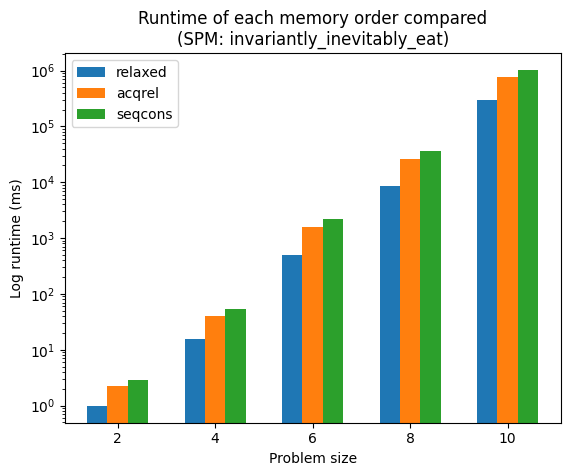

Seqcons/Rlx:
problemsize
2     2.936359
4     3.381883
6     4.335268
8     4.166275
10    3.506469
Name: runtime, dtype: float64
Seqcons/AcqRel:
problemsize
2     1.280659
4     1.297986
6     1.370572
8     1.387568
10    1.356856
Name: runtime, dtype: float64
AcqRel/Rlx:
problemsize
2     2.292850
4     2.605486
6     3.163108
8     3.002573
10    2.584260
Name: runtime, dtype: float64


In [7]:
for f, rows in per_formula:
    ys = bar_chart(
        rows,
        f"Runtime of each memory order compared\n(SPM: {f})",
        "memorder",
        ["relaxed", "acqrel", "seqcons"]
    );
    
    print(f"Seqcons/Rlx:");
    print(ys[2]/ys[0]);

    print(f"Seqcons/AcqRel:");
    print(ys[2]/ys[1]);

    print(f"AcqRel/Rlx:");
    print(ys[1]/ys[0]);
    

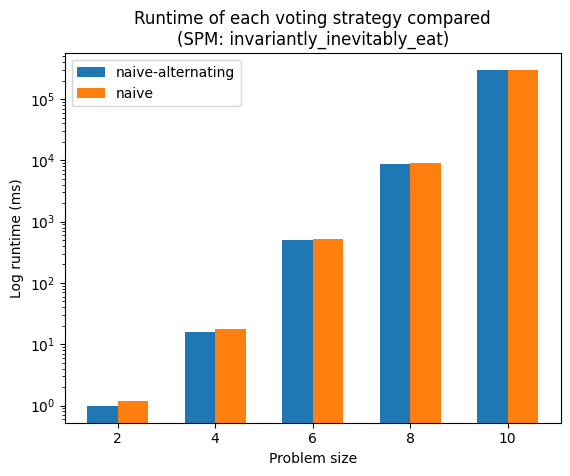

Naive/Naive-alternating:
problemsize
2     1.184838
4     1.116869
6     1.041462
8     1.027034
10    1.019324
Name: runtime, dtype: float64


In [8]:
for f, rows in per_formula:
    ys = bar_chart(
        rows,
        f"Runtime of each voting strategy compared\n(SPM: {f})",
        "voting-strat",
        ["naive-alternating", "naive"]
    );
    print(f"Naive/Naive-alternating:");
    print(ys[1]/ys[0]);

    
    

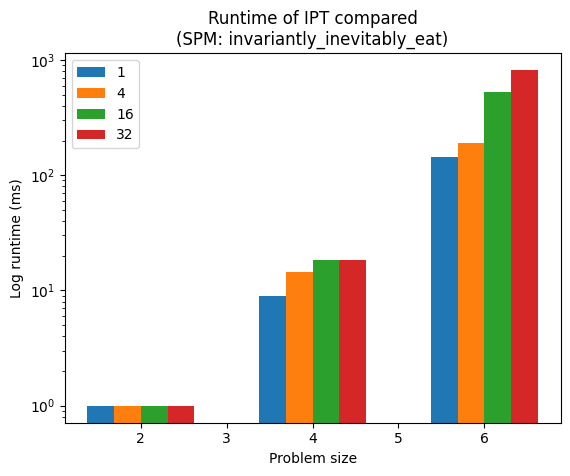

In [9]:
for f, rows in per_formula:
    ys = bar_chart(
        rows,
        f"Runtime of IPT compared\n(SPM: {f})",
        "ipt",
        [1, 4, 16, 32]
    );


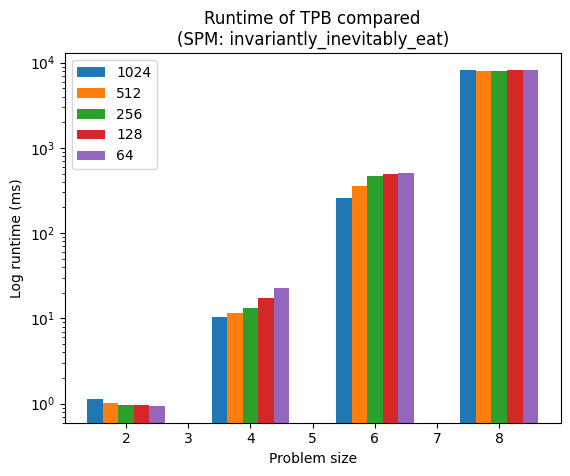

In [10]:
for f, rows in per_formula:
    ys = bar_chart(
        rows,
        f"Runtime of TPB compared\n(SPM: {f})",
        "tpb",
        [1024, 512, 256, 128, 64]
    );

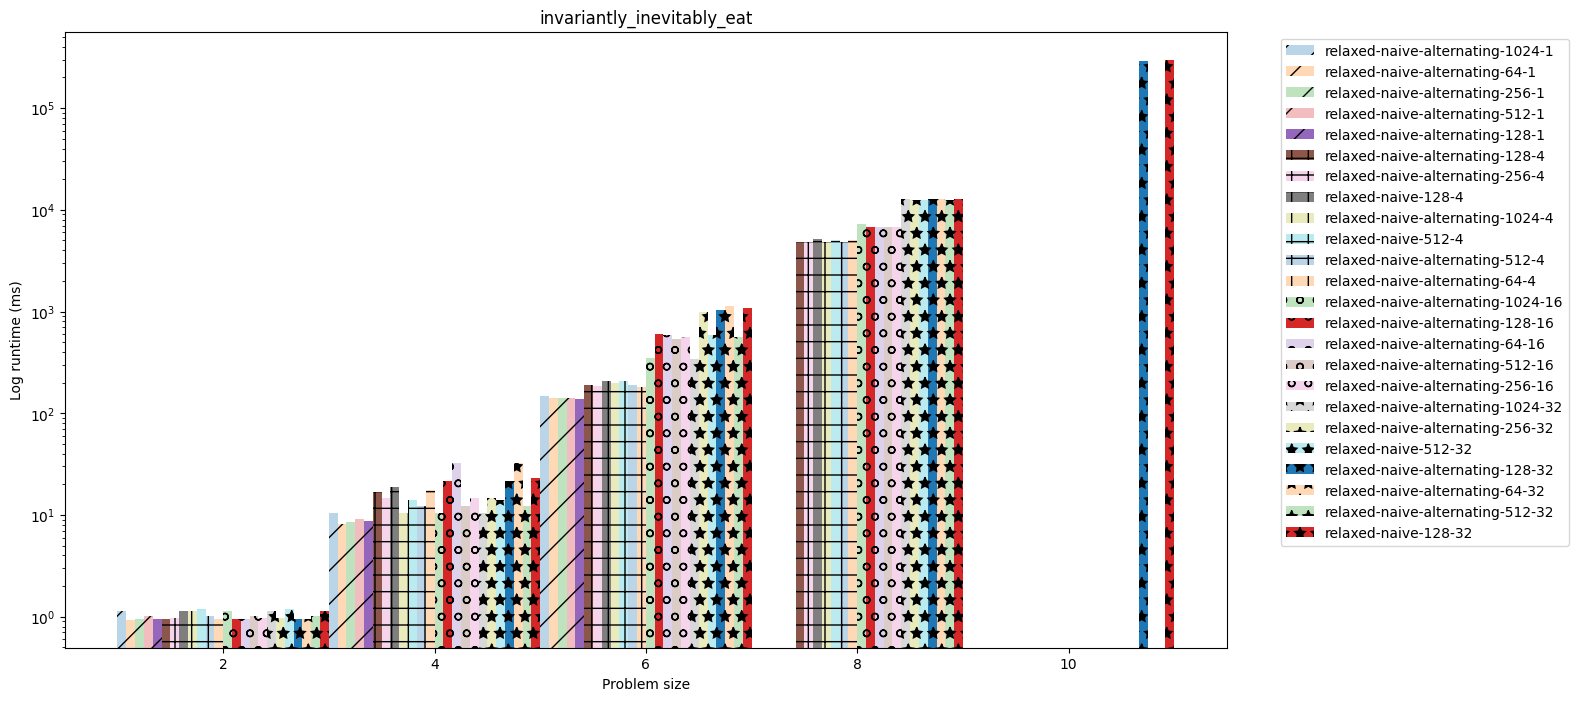

In [11]:
tot_width = 2;

for f, rows in per_formula:
    if f != "invariantly_inevitably_eat":
        continue;
        
    configs = rows.sort_values(by=['ipt'])["config"].unique();
    configs = [c for c in configs if c.startswith("relaxed")];
    width =  tot_width / len(configs);
    offset = - 0.5 * tot_width + 0.5 * width;
    
    plt.figure(figsize=(15,8));
    plt.title(f"{f}")
    ys = [];
    for c in configs:
        c_rows = rows[rows["config"] == c];
        X = c_rows["problemsize"];
        Y = c_rows["runtime"];
        if c_rows["ipt"].iloc[0] == 1:
            h = '/';
        elif c_rows["ipt"].iloc[0] == 16:
            h = 'o';
        elif c_rows["ipt"].iloc[0] == 32:
            h = '*';
        else:
            h = '+';
        
        if c_rows["tpb"].iloc[0] == 128:
            a = 1;
        else:
            a = 0.3;
        
        plt.bar(X + offset, Y, width, label=c, hatch=h, alpha=a);
        offset += width;
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
    plt.xlabel("Problem size");
    plt.ylabel("Log runtime (ms)");
    plt.yscale("log");
    plt.show();
